# Additional Tutorial 1: Work for multiple sections (without batch effects)

Here we show STAGATE's ablility to identify spatial domains for multiple sections.

The DLPFC samples (151673-51676) are used in this tutorial.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
import STAGATE

In [3]:
section_list = ['151673', '151674', '151675', '151676']

## Load Data

In [4]:
adata_list = {}
for section_id in section_list:
    input_dir = os.path.join('../Data', section_id, 'Data')
    temp_adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
    temp_adata.var_names_make_unique()
    
    Truth_df = pd.read_csv(os.path.join('../Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
    temp_adata.obs['Ground Truth'] = Truth_df.loc[temp_adata.obs_names, 1]
    # make the spot name unique
    temp_adata.obs_names = [x+'_'+section_id for x in temp_adata.obs_names]
    
    adata_list[section_id] = temp_adata.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


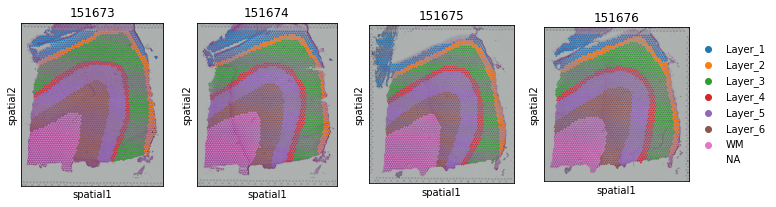

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["Ground Truth"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["Ground Truth"], title=section_id, show=False)
    it+=1

## Constructing the spatial network for each secion

------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


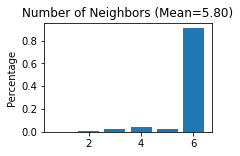

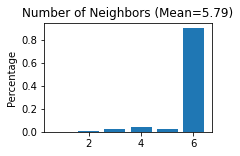

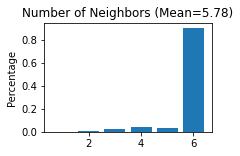

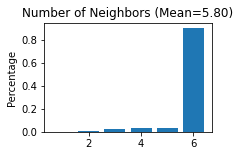

In [6]:
for section_id in section_list:
    STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

### Note that the spatial network are saved in adata.uns['Spatial_Net'], which can be conbat directly for multiple sections.

In [7]:
adata_list['151673'].uns['Spatial_Net']

,Cell1,Cell2,Distance
0,AAACAAGTATCTCCCA-1_151673,AGAGGCTTCGGAAACC-1_151673,138.061580
2,AAACAAGTATCTCCCA-1_151673,ACTAGTTGCGATCGTC-1_151673,138.003623
3,AAACAAGTATCTCCCA-1_151673,GCATCGGCCGTGTAGG-1_151673,138.061580
4,AAACAAGTATCTCCCA-1_151673,CAGCAGTCCAGACTAT-1_151673,138.003623
5,AAACAAGTATCTCCCA-1_151673,TTCTTATCCGCTGGGT-1_151673,137.927517
...,...,...,...
1,TTGTTTGTGTAAATTC-1_151673,GCCTATTTGCTACACA-1_151673,138.061580
2,TTGTTTGTGTAAATTC-1_151673,GTAGCGCTGTTGTAGT-1_151673,138.798415
4,TTGTTTGTGTAAATTC-1_151673,TTAAACCGGTAGCGAC-1_151673,137.927517
5,TTGTTTGTGTAAATTC-1_151673,GGATCAAAGGACGAGG-1_151673,138.423264


## Conbat the scanpy objects and spatial networks

In [8]:
adata = sc.concat([adata_list[x] for x in section_list], keys=None)

In [9]:
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in section_list])

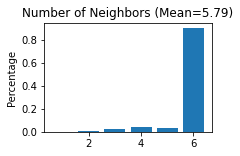

In [10]:
STAGATE.Stats_Spatial_Net(adata)

## Normalization

In [11]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Running STAGATE

In [12]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (14364, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


In [13]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [14]:
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [15]:
adata.obs['Sample'] = [x.split('_')[-1] for x in adata.obs_names]

... storing 'Sample' as categorical


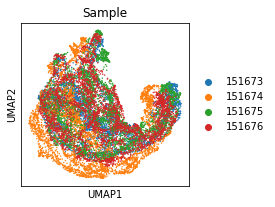

In [16]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Sample')

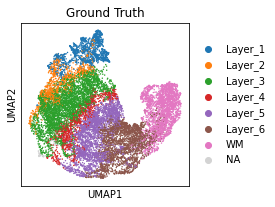

In [17]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Ground Truth')

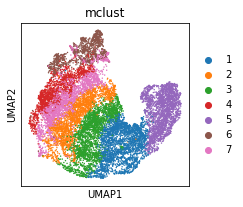

In [18]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='mclust')

In [19]:
temp_adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

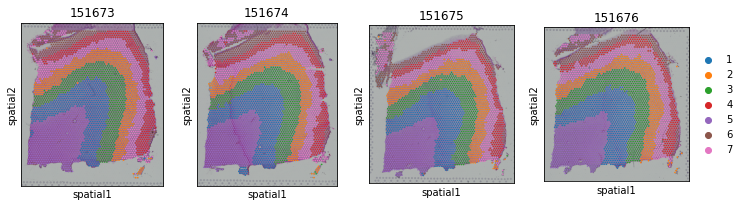

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    adata_list[section_id].obs['STAGATE'] = adata.obs.loc[adata_list[section_id].obs_names, 'mclust']
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["STAGATE"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["STAGATE"], title=section_id, show=False)
    it+=1

## Calculate ARI

In [21]:
from sklearn.metrics.cluster import adjusted_rand_score

In [22]:
for section_id in section_list:
    temp_adata = adata[adata.obs['Sample']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

ARI of section ID 151673: 0.564
ARI of section ID 151674: 0.650
ARI of section ID 151675: 0.627
ARI of section ID 151676: 0.620
